In [5]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

In [2]:
# Read file with chart
df = pd.read_csv('./gemini_ETHUSD_2020_1min.csv', skiprows=[0]) # Read in data
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1609459140000,2020-12-31 23:59:00,ETHUSD,738.00,738.03,737.39,737.39,0.997336
1,1609459080000,2020-12-31 23:58:00,ETHUSD,738.66,738.66,738.00,738.00,1.190000
2,1609459020000,2020-12-31 23:57:00,ETHUSD,738.13,738.66,738.13,738.66,12.519947
3,1609458960000,2020-12-31 23:56:00,ETHUSD,738.48,738.48,738.13,738.13,1.312525
4,1609458900000,2020-12-31 23:55:00,ETHUSD,738.87,738.87,738.48,738.48,0.204095


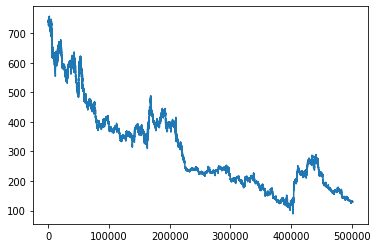

In [3]:
# Pot chart
plt.plot(df['Open'])

In [49]:
# Since it is a reverse order, sort the chart ascendingly
df=df.sort_values(by=['Date'])
df=df.reset_index(drop=True) # Reset old index
df.head(10)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1577836800000,2020-01-01 00:00:00,ETHUSD,128.84,128.84,128.74,128.74,0.010000
1,1577836860000,2020-01-01 00:01:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
2,1577836920000,2020-01-01 00:02:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
3,1577836980000,2020-01-01 00:03:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
4,1577837040000,2020-01-01 00:04:00,ETHUSD,128.74,128.74,128.49,128.50,4.039458
5,1577837100000,2020-01-01 00:05:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
6,1577837160000,2020-01-01 00:06:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
7,1577837220000,2020-01-01 00:07:00,ETHUSD,128.50,128.50,128.41,128.41,1.627411
8,1577837280000,2020-01-01 00:08:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000
9,1577837340000,2020-01-01 00:09:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000


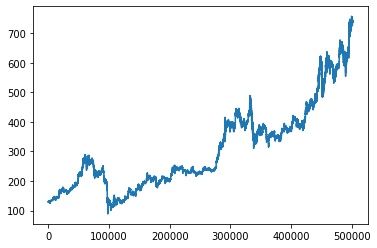

In [5]:
# Plot again
plt.plot(df['Open'])

In [6]:
# Show growth over the time
print("Open:", df.at[0, 'Open'])
print("Close:", df.at[df.shape[0] - 1, 'Open'])
growth = ((df.at[df.shape[0] - 1, 'Open'] / df.at[0, 'Open']) - 1) * 100
print("Growth:", round(growth, 3), "%")

Open: 128.84
Close: 738.0
Growth: 472.803 %


# Creation of a class for the (simulated) real-time crypto chart

In [6]:
class RealTimeChart:
    def __init__(self, path):
        '''
        INPUT:
        path - Path to a crypto chart file
    
        Description:
        Creates a new chart based on a loaded crypto chart
        ''' 
        self.df = pd.read_csv(path, skiprows=[0])  # Read file with chart
        self.df = self.df.sort_values(by=['Date']) # Since it is in a reverse order, sort the chart ascendingly
        self.df = self.df.reset_index(drop=True)   # Reset old index
        
        # Set the index to 0
        self.index = 0

    def visualize(self):
        '''
        Description:
        Simply plots the whole chart
        ''' 
        plt.plot(self.df['Open'])
        
    def get_current_price(self):
        '''
        OUTPUT:
        price
        
        Description:
        Return the current price.
        '''
        price = self.df.at[self.index, 'Open']
        if self.index > (self.df.shape[0] - 1):
            price = 0
        return price

    def get_next_price(self):
        '''
        Description:
        Return the next price. Can be used to simulate a real-time price.
        '''
        price = self.df.at[self.index, 'Open']
        self.index+=1
        if self.index > (self.df.shape[0] - 1):
            price = 0
        return price
    
    def has_next_price(self):
        '''
        Description:
        Returns True if there is another price in the chart (False if not).
        '''
        if self.index > (self.df.shape[0] - 1):
            return False
        else:
            return True


In [68]:
class Wallet:
    def __init__(self, fiat):
        '''
        INPUT:
        fiat - Initial budget in FIAT currancy
    
        Description:
        Creates a new wallet with an initial budget
        ''' 
        self.fiat = fiat
        self.crypto = 0

    def buy_crypto(self, amount, price, charge_fee_percentage):
        '''
        INPUT:
        amount - Units of crypto currency to be bought
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from amount value)

        Description:        
        Buy a defined amount of a crypto currancy.
        Returns True if order was successful (False if not)
        ''' 
        if (amount * price) <= self.fiat:
            self.fiat = self.fiat - (amount * price)
            self.crypto = self.crypto + (amount - (amount * charge_fee_percentage))
            print(amount, "crypto units bought for unit price of", price, "FIAT (Overall price:", amount * price, "FIAT)")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", (amount - (amount * charge_fee_percentage)), "new crypto units in wallet")
            return True
        else:
            return False
        
    def sell_crypto(self, amount, price, charge_fee_percentage):
        '''
        INPUT:
        amount - Units of crypto currency to be sold
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from overall sales price)

        Description:        
        Sells a defined amount of a crypto currancy.
        Returns True if order was successful (False if not)
        '''
        if amount <= self.crypto:
            self.crypto = self.crypto - amount
            self.fiat = self.fiat + ((amount * price) - (amount * price * charge_fee_percentage))
            print(amount, "crypto units sold for unit price of", price, "FIAT (Overall price:", amount * price, "FIAT)")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", ((amount * price) - (amount * price * charge_fee_percentage)), "new FIAT units in wallet")
            return True
        else:
            return False
    
    def get_eur(self):
        '''
        OUTPUT:
        self.fiat
        
        Description:
        Returns current number of euros.
        '''
        return self.fiat

    def get_crypto(self):
        '''
        OUTPUT:
        self.crypto
        
        Description:
        Returns current units of crypto currancy.
        '''
        return self.crypto

    def get_value(self, price):
        '''
        INPUT:
        price - Current price of crypto currancy in FIAT 
        
        OUTPUT:
        value - Current value of the wallet
        
        Description:
        Calculates the value of the wallet by adding value of crypto units with FIAT.
        '''
        return self.fiat + (self.crypto * price)
    
    def to_string(self, price):
        print("----------------")
        print("FIAT: ", self.fiat)
        print("CRYP: ", self.crypto, "->", self.crypto * price, "FIAT")
        print("SUM: ", self.get_value(price), "(FIAT)")
        print("----------------")


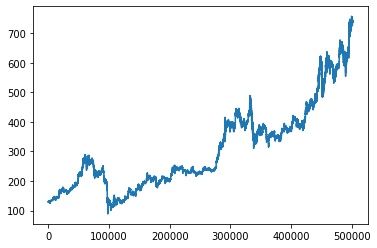

In [31]:
myChart = RealTimeChart('./gemini_ETHUSD_2020_1min.csv')
myChart.visualize()

In [69]:
myWallet = Wallet(1000)
myWallet.to_string(1000)
myWallet.buy_crypto(10, 50, 0.005)
myWallet.to_string(50)
myWallet.sell_crypto(myWallet.get_crypto(), 50, 0.005)
myWallet.to_string(50)

----------------
FIAT:  1000
CRYP:  0 -> 0 FIAT
SUM:  1000 (FIAT)
----------------
10 crypto units bought for unit price of 50 FIAT (Overall price: 500 FIAT)
Charge fee:  0.5 % -> 9.95 new crypto units in wallet
----------------
FIAT:  500
CRYP:  9.95 -> 497.49999999999994 FIAT
SUM:  997.5 (FIAT)
----------------
9.95 crypto units sold for unit price of 50 FIAT (Overall price: 497.49999999999994 FIAT)
Charge fee:  0.5 % -> 495.01249999999993 new FIAT units in wallet
----------------
FIAT:  995.0124999999999
CRYP:  0.0 -> 0.0 FIAT
SUM:  995.0124999999999 (FIAT)
----------------
